In [1]:
! git clone https://github.com/openai/point-e


Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 7), reused 51 (delta 7), pack-reused 0
Receiving objects: 100% (57/57), 1.56 MiB | 34.09 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
%cd point-e

/content/point-e


In [3]:
pip install -e .

Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-roaxsn1c/clip_ba463c3686a648778d47741c76876f26
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-roaxsn1c/clip_ba463c3686a648778d47741c76876f26
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=eeeee625a089f34740be3acc560c0949eb32604a6fc3bae75cd0d2e943fac45e
  Stored in directory: /tmp/pip-ephem-wheel-cache-i98_71kz/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
  Created wheel for fire: filename=fire-0.5.0-py

In [5]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:08<00:00, 112MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [7]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [18]:
# Load an image to condition on.
img = Image.open('/content/point-e/point_e/examples/example_data/elephant.jpg')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x

0it [00:00, ?it/s]

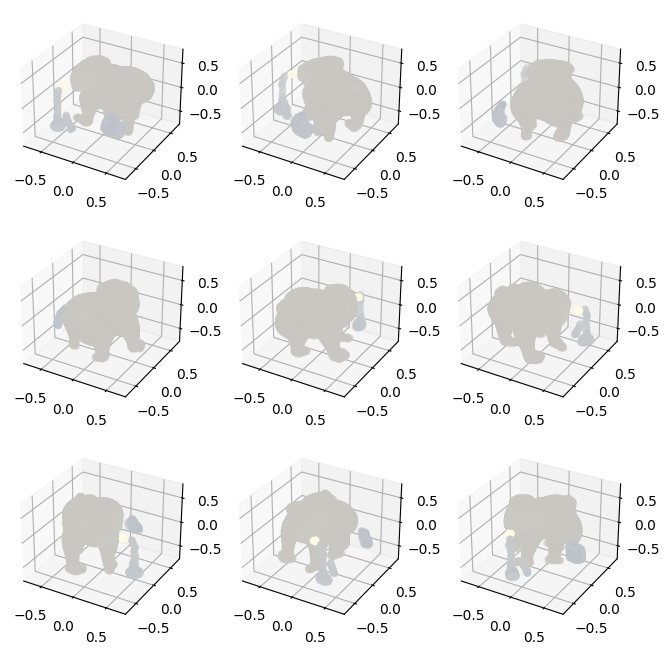

In [17]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))